In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

## Подготовка данных

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')

In [3]:
data.shape

(354369, 16)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Вывод:** видим не очень большой датафрейм (всего 16 признаков), но с большим количеством записей. Явно есть пропуски, незначимые признаки и другие проблемы, начнем его изучение.

### Поиск простых дубликатов

Пока мы не выполнили преобразований над данными (не убрали лишние столбцы с датой), можно проверить их на простые дубликаты.

In [6]:
data.duplicated().sum()

4

In [7]:
data = data.drop_duplicates()

**Вывод:** в данных было всего 4 полных дубликата, удалили их.

### Удаление ненужных данных

Вначале посмотрим, когда были выгружены анкеты

In [8]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')

In [9]:
data['DateCrawled'].dt.year.unique()

array([2016], dtype=int64)

Нам не нужны признаки, связанные с владельцем: `NumberOfPictures`, `PostalCode` и `LastSeen`, а также дата скачивания анкеты `DateCrawled`. Врядли сильно влияет на цену месяц регистрации `RegistrationMonth`.

Удалим эти признаки.

In [10]:
data = data.drop(['PostalCode', 'LastSeen', 'DateCrawled', 'RegistrationMonth', 'NumberOfPictures'], axis=1)

**Вывод:** избавились от неинформативных признаков `NumberOfPictures`, `PostalCode`, `LastSeen`, `DateCrawled` и `RegistrationMonth`.

### Переименования колонок

In [11]:
data = data.rename(str.lower, axis='columns')

data = data.rename(columns={
    'vehicletype': 'vehicle_type',
    'registrationyear': 'registration_year',
    'fueltype': 'fuel_type',
    'datecreated': 'date_created'
})

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       316875 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            334532 non-null  object
 4   power              354365 non-null  int64 
 5   model              334660 non-null  object
 6   kilometer          354365 non-null  int64 
 7   fuel_type          321470 non-null  object
 8   brand              354365 non-null  object
 9   repaired           283211 non-null  object
 10  date_created       354365 non-null  object
dtypes: int64(4), object(7)
memory usage: 32.4+ MB


**Вывод:** привели названия колонок к станадртному виду.

### Проверка необходимости учета инфляции

Дата создания тоже нам не нужна, но, наверное, стоит проверить хотя бы год создания, чтобы удостоверится, что в цены не внесет свой вклад инфляция.

Приведем столбец `DateCreated` к нужному типу и посчитаем, сколько различных лет охватывает наш датасет.

In [13]:
data['date_created'] = pd.to_datetime(data['date_created'], format='%Y-%m-%d %H:%M:%S')

data['date_created'].dt.year.unique()

array([2016, 2015, 2014], dtype=int64)

In [14]:
data = data.drop(['date_created'], axis=1)

В целом, 3 года - большой срок. Однако непонятно, какой уровень среднегодовой инфляции принять, так как мы не знаем страну. Пока удалю эти данные.

**Вывод:** удилили дату создания объявления.

### Поиск пропусков

Посмотрим, сколько всего имеется пропусков.

In [15]:
data.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

Много где нет информации о ремонтах. Проверим, какое соотношение отремонтированных/не бывших в ремонте машин.

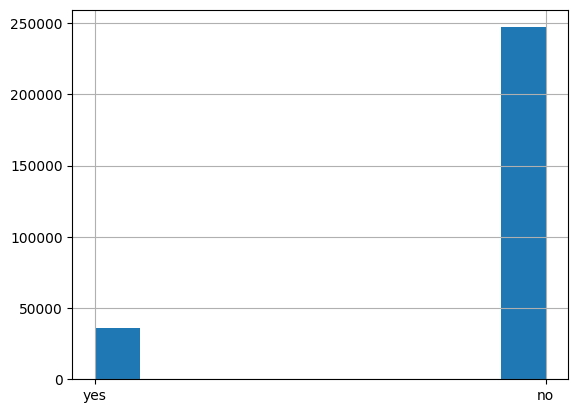

In [16]:
data['repaired'].hist();

Проще всего заполнить пропуски значением `0` - машина не ремонтировалась.

In [17]:
data['repaired'] = data['repaired'].fillna(0)

Разберемся с остальными колонками. Они все связаны с конструкцией машины. Скорее всего, наиболее праильным будет заполнить их значениями, характерными для этих машин. Модель восстановить адекватно никак не получится, признаки в этой колонке удалим.

А вот остальные заполним по наиболее популярному для данной модели значению.

In [18]:
data = data[data['model'].notna()]

In [19]:
columns_pass = ['vehicle_type', 'fuel_type', 'gearbox']

In [20]:
def get_fill_value(data, key):
    key = tuple(key) if key.shape[0] > 1 else key[0]
    return data.loc[key] if data.index.isin([key]).any() else np.nan

In [21]:
%%time
for column in tqdm(columns_pass):
    group_list = ['brand', 'model']

    fill_values = data.groupby(group_list)[column].agg(lambda x: x.value_counts().idxmax())
    empty_idx = data[data[column].isna()].index

    data.loc[empty_idx, column] = data.loc[empty_idx][group_list].apply(lambda x: get_fill_value(fill_values, x), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:21<00:00, 27.02s/it]

CPU times: total: 1min 20s
Wall time: 1min 21s


In [22]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

**Вывод:** заполнение пропусков выполнили, отлично. 

- В признаке `repaired` пропуски заменены на 0.
- Пропуски в признаке `model` удалили.
- В признаках `vehicle_type`, `fuel_type`, `gearbox` - заменили на наиболее часто встречающийся тип для данной модели.

### Смена типов данных

Неправильный тип данных в колонках `repaired` и `gearbox` - должен быть булев. Остальные колонки правильные. Заменим значения в колонках на 1 или 0.

In [23]:
data['is_auto_gearbox'] = data['gearbox'].map({'auto': 1, 'manual': 0})
data = data.drop(['gearbox'], axis=1)

In [24]:
data['repaired'] = data['repaired'].map({'yes': 1, 'no': 0}) 

In [25]:
data['repaired'] = data['repaired'].astype('bool')
data['is_auto_gearbox'] = data['is_auto_gearbox'].astype('bool')

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334660 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              334660 non-null  int64 
 1   vehicle_type       334660 non-null  object
 2   registration_year  334660 non-null  int64 
 3   power              334660 non-null  int64 
 4   model              334660 non-null  object
 5   kilometer          334660 non-null  int64 
 6   fuel_type          334660 non-null  object
 7   brand              334660 non-null  object
 8   repaired           334660 non-null  bool  
 9   is_auto_gearbox    334660 non-null  bool  
dtypes: bool(2), int64(4), object(4)
memory usage: 31.7+ MB


**Вывод:** типы данных теперь правильные. Выполнена замена типов в признаках `repaired` и `gearbox` на bool. Для последнего создан новый признак `is_auto_gearbox`, а прошлый удален.

### Поиск сложных дубликатов

Проверим дубликаты в категориальных признаках.

In [27]:
data.vehicle_type.unique()

array(['sedan', 'suv', 'small', 'convertible', 'bus', 'wagon', 'coupe',
       'other'], dtype=object)

In [28]:
data.model.unique()

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'ma

In [29]:
data.fuel_type.unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [30]:
data.brand.unique()

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'opel', 'seat', 'citroen',
       'honda', 'fiat', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo',
       'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'porsche', 'rover', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

**Вывод:** сложных дубликатов в категориальных признаках не замечено.

### Удаление выбросов

Вначале разделим признаки на численные и категориальные.

In [31]:
data_numeric = data.select_dtypes(include=[np.number])
numeric_cols = data_numeric.columns.values
print('Числовые колонки:', numeric_cols)

data_non_numeric = data.select_dtypes(exclude=[np.number, 'datetime', 'bool'])
non_numeric_cols = data_non_numeric.columns.values
print('Категориальные колонки:',non_numeric_cols)

Числовые колонки: ['price' 'registration_year' 'power' 'kilometer']
Категориальные колонки: ['vehicle_type' 'model' 'fuel_type' 'brand']


Теперь посмотрим на выбросы в числовых колонках.

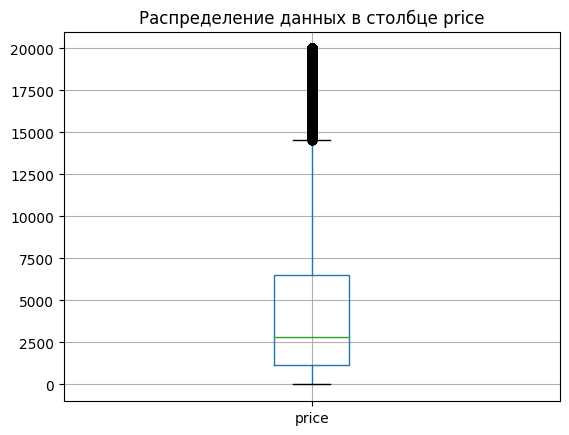

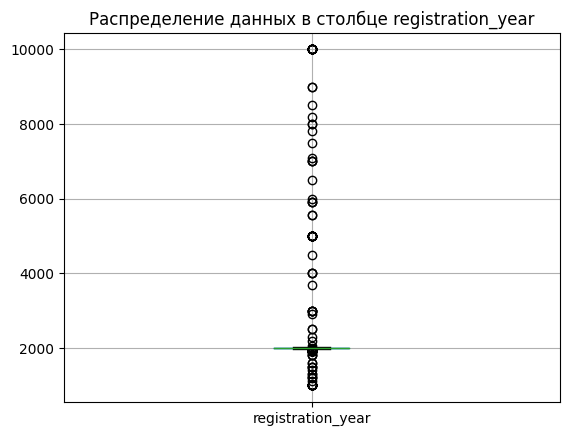

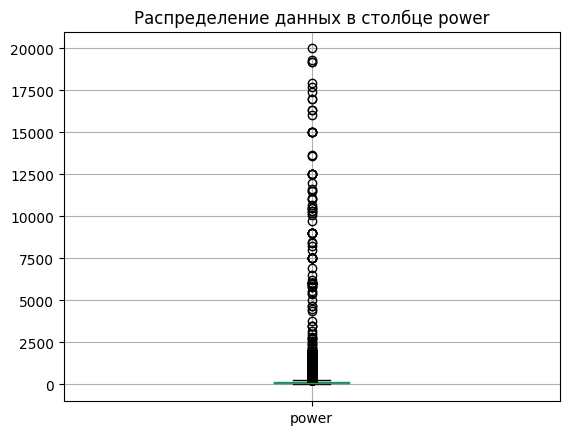

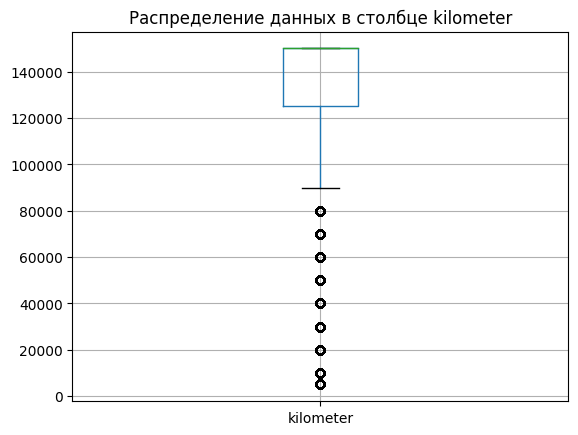

In [32]:
for column in numeric_cols:
    fig, ax = plt.subplots()
    ax = data.boxplot(column=column).set_title(f'Распределение данных в столбце {column}')

Признаки `power` и `registration_year` явно нуждаются в очистке. Не может быть 10000 год регистрации, как и 20 000 л.с. в машине. Ограничим их физически осуществимыми значениями.

In [33]:
data.registration_year.describe(percentiles=[.01, .5, .99])

count    334660.000000
mean       2003.924024
std          69.377633
min        1000.000000
1%         1982.000000
50%        2003.000000
99%        2018.000000
max        9999.000000
Name: registration_year, dtype: float64

In [34]:
data = data.query('registration_year <= 2016 & registration_year >= 1960')

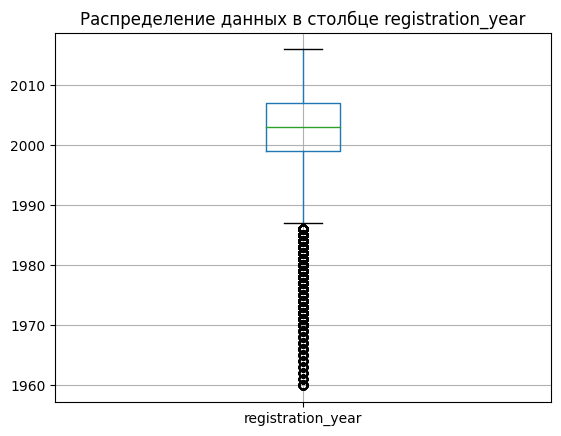

In [35]:
data.boxplot(column='registration_year').set_title('Распределение данных в столбце registration_year');

In [36]:
data.power.describe(percentiles=[.01, .5, .99])

count    321950.000000
mean        112.270005
std         182.023515
min           0.000000
1%            0.000000
50%         105.000000
99%         300.000000
max       20000.000000
Name: power, dtype: float64

In [37]:
data = data.query('power <= 400 & power > 10')

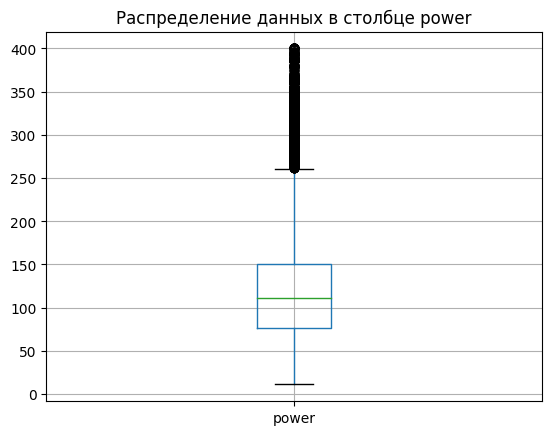

In [38]:
data.boxplot(column='power').set_title('Распределение данных в столбце power');

Числовые колонки почистили, теперь посмотрим на категориальные.

In [39]:
for column in non_numeric_cols:
    print(column)
    print(data[column].value_counts().tail(10))
    print('')

vehicle_type
sedan          86458
small          71678
wagon          59782
bus            26834
convertible    18368
coupe          14441
suv            10585
other           2316
Name: vehicle_type, dtype: int64

model
kappa                 13
gl                    12
elefantino             7
i3                     5
serie_2                5
samara                 5
kalina                 5
serie_3                3
range_rover_evoque     2
rangerover             2
Name: model, dtype: int64

fuel_type
petrol      195621
gasoline     89554
lpg           4504
cng            472
hybrid         180
other           74
electric        57
Name: fuel_type, dtype: int64

brand
porsche       578
jeep          556
saab          469
land_rover    461
jaguar        435
daewoo        388
lancia        375
rover         333
trabant       284
lada          154
Name: brand, dtype: int64



Довольно мало автомобилей с типома топлива `other` и `electric` - можно их удалить.

In [40]:
data = data[~data['fuel_type'].isin(['other', 'electric'])]

Посмотрим отдельно на признак `model`

In [41]:
data.model.value_counts().tail(20)

lodgy                 30
delta                 28
b_max                 25
9000                  24
musa                  21
charade               20
materia               17
200                   16
amarok                15
q3                    14
kappa                 13
gl                    12
elefantino             7
i3                     5
serie_2                5
samara                 5
kalina                 5
serie_3                3
rangerover             2
range_rover_evoque     2
Name: model, dtype: int64

Довольно много моделей, представленных менее чем 20 объявлениями - избавимся и от них.

In [42]:
data = data[~data['model'].isin(data.model.value_counts().tail(14).index)]

Теперь посмотрим на целевой признак, `price`

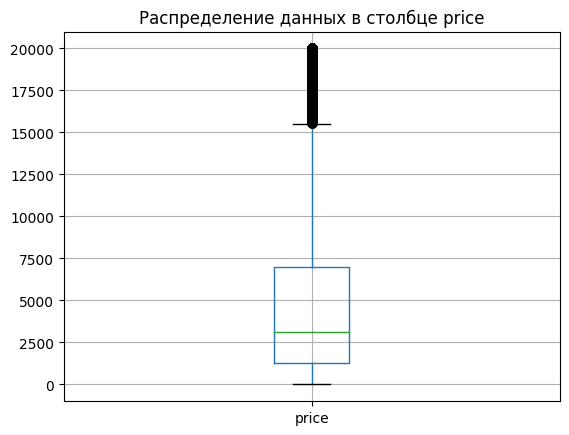

In [43]:
data.boxplot(column='price').set_title('Распределение данных в столбце price');

Немного странным кажется то, что цены начинаются с 0. Немного ограничим их снизу.

In [44]:
data = data[data['price'] > 10]

**Вывод:** избавились от выбросов в числовых и категориальных признаках. Были удалены:

* Объявления с годом регистрации автомобиля ранее 1960 и позднее 2018.
* Объявления с мощностью автомобиля менее 11 и более 400 л.с.
* Объявления с типом топлива `other` и `eletcric`.
* Объявления с моделями, представленными менее чем 20 объявлениями.
* Объявления с ценой менее 10


### Изучение корреляций

In [45]:
data[numeric_cols].corr()

,price,registration_year,power,kilometer
price,1.000000,0.518665,0.509948,-0.395031
registration_year,0.518665,1.000000,0.142586,-0.325049
power,0.509948,0.142586,1.000000,0.106613
kilometer,-0.395031,-0.325049,0.106613,1.000000


**Вывод:** сильно скореллированных друг с другом обучающих признаков нет.

### Вывод

Подготовили данные: переименовали колонки, удалили дубликаты, привели правильные типы, избавились от выбросов и заполнили пропуски. Можно приступать к обучению.

## Обучение моделей

### Разделение датасетов

Разделим наши данные на обучающую, валидационную и тестовую выборки. Выбираем разделение 80:10:10, обучим модель на 80%, валидационная выборка составит 10%, тестовая также 10%.

In [46]:
features = data.drop(['price'], axis=1)
target = data['price']

In [47]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.2, random_state=1)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=1)

In [48]:
print('Обучающая выборка: признаки', features_train.shape)
print('Валидационная выборка: признаки', features_valid.shape)
print('Тестовая выборка: признаки', features_test.shape)
print('')
print('Обучающая выборка: цель', target_train.shape)
print('Валидационная выборка: цель', target_valid.shape)
print('Тестовая выборка: цель', target_test.shape)

Обучающая выборка: признаки (227230, 9)
Валидационная выборка: признаки (28404, 9)
Тестовая выборка: признаки (28404, 9)

Обучающая выборка: цель (227230,)
Валидационная выборка: цель (28404,)
Тестовая выборка: цель (28404,)


Признаки разделили, можно приступать к обучению. По условию, нам надо применить одну модель градиентного бустинга и как минимум одну - не бустинга. Выберем 3 модели: `LightGBM`, `LinearRegression`, `RandomForestRegressor`.

Для `LigthGBM` достаточно провести ordinal encoding категориальных признаков. Поэтому вначале попробуем поработать с бустингом, затем перейдем на более простые модели. Из них, для регрессии необходима дополнительно стандартизация признаков, исходя из этого, приходим к следующему порядку использования моделей:

- LigthGBM - LGBMRegressor
- RandomForestRegressor
- LinearRegression

### Ordinal Encoding

Для начала проведем Ordinal Encoding на категориальных признаках. Это в любом случае понадобится для LightGBM модели.

In [49]:
for col in non_numeric_cols:
    models_train = set(features_train[col].unique())
    models_valid = set(features_valid[col].unique())
    models_test = set(features_test[col].unique())

    print(f'Не попало в тренировочную для признака "{col}" {models_test - models_train}, {models_valid - models_train}')

Не попало в тренировочную для признака "vehicle_type" set(), set()
Не попало в тренировочную для признака "model" set(), set()
Не попало в тренировочную для признака "fuel_type" set(), set()
Не попало в тренировочную для признака "brand" set(), set()


В тренировочную выборку попали все возможные варианты признаков, отлично.

In [50]:
oe = OrdinalEncoder(handle_unknown='error')

oe.fit(features_train[non_numeric_cols])
features_train[non_numeric_cols] = oe.transform(features_train[non_numeric_cols])
features_valid[non_numeric_cols] = oe.transform(features_valid[non_numeric_cols])
features_test[non_numeric_cols] = oe.transform(features_test[non_numeric_cols])

### LGBMRegressor

Обучим модель LGBMRegressor, будем варьировать гиперпараметрами learning_rate и n_estimators. Выберем наилучшую модель по RMSE и посчитаем ее время работы

In [51]:
%%time
test_of_lgb_model = pd.DataFrame(columns=['learning_rate', 'n_estimators', 'rmse'])
for est in tqdm(range(50, 250, 50)):
    for rates in tqdm(np.arange(0.05, 0.4, 0.05)):
        lgb_model = lgb.LGBMRegressor(
            n_estimators=est, 
            learning_rate=rates
        )
        lgb_model.fit(features_train, target_train)
        lgb_pred = lgb_model.predict(features_valid)
        test_of_lgb_model = test_of_lgb_model.append(
            pd.DataFrame([[rates, est, mean_squared_error(target_valid, lgb_pred) ** .5]],
                         columns=['learning_rate', 'n_estimators', 'rmse']
                        ), ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:33<00:00,  8.43s/it]

CPU times: total: 3min 30s
Wall time: 33.7 s


In [52]:
test_of_lgb_model.sort_values(by='rmse', ascending=True)

,learning_rate,n_estimators,rmse
26,0.30,200,1534.668081
27,0.35,200,1538.315253
25,0.25,200,1540.065907
24,0.20,200,1550.262993
19,0.30,150,1550.708063
20,0.35,150,1553.715970
18,0.25,150,1558.164219
17,0.20,150,1566.312725
23,0.15,200,1567.012235
13,0.35,100,1577.222099


Выбираем модель с гиперпараметрами `n_estimators=200`, `learning_rate=0.3`.

In [53]:
lgb_model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.3)

In [54]:
%%time
lgb_model.fit(features_train, target_train);

CPU times: total: 6.55 s
Wall time: 1.07 s


LGBMRegressor(learning_rate=0.3, n_estimators=200)

In [55]:
%%time
lgb_pred = lgb_model.predict(features_valid)

CPU times: total: 547 ms
Wall time: 78.7 ms


In [56]:
mean_squared_error(target_valid, lgb_pred) ** .5

1534.6680807982677

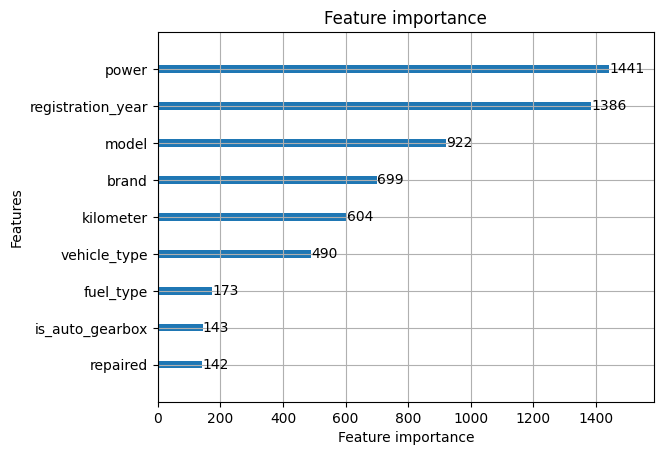

In [57]:
_ = lgb.plot_importance(lgb_model)

### Random Forest

Обучим модель Random Forest, будем варьировать гиперпараметрами n_estimators и max_depth. Выберем наилучшую модель по RMSE и посчитаем ее время работы.

In [58]:
test_rf = pd.DataFrame(columns=['n_estimators', 'max_depth', 'rmse'])

for est in tqdm(range(10, 60, 10)):
    for depth in tqdm(range(10, 50, 10)):
        rf_model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=0)
        rf_model.fit(features_train, target_train)
        rf_pred = rf_model.predict(features_valid)
        test_rf = test_rf.append(
            pd.DataFrame([[est, depth, mean_squared_error(target_valid, rf_pred) ** .5]],
            columns=['n_estimators', 'max_depth', 'rmse']), ignore_index=True
        )

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:00<00:00, 72.12s/it]


In [59]:
test_rf.sort_values(by='rmse', ascending=True)

,n_estimators,max_depth,rmse
17,50,20,1519.322954
13,40,20,1522.253644
9,30,20,1526.710444
19,50,40,1529.758534
5,20,20,1530.222192
18,50,30,1531.268534
15,40,40,1533.859999
14,40,30,1535.627623
11,30,40,1538.843971
10,30,30,1539.992755


Выбираем модель с гиперпараметрами `n_estimators=20`, `max_depth=20` - по ошибке они близко всего к предыдущей модели, а по их значению модель должна обучаться быстрее остальных.

In [60]:
rf_model = RandomForestRegressor(n_estimators=20, max_depth=20, random_state=0)

In [61]:
%%time
rf_model.fit(features_train, target_train);

CPU times: total: 12.4 s
Wall time: 12.9 s


RandomForestRegressor(max_depth=20, n_estimators=20, random_state=0)

In [62]:
%%time
rf_pred = rf_model.predict(features_valid)

CPU times: total: 188 ms
Wall time: 217 ms


In [63]:
mean_squared_error(target_valid, rf_pred) ** .5

1530.2221916895367

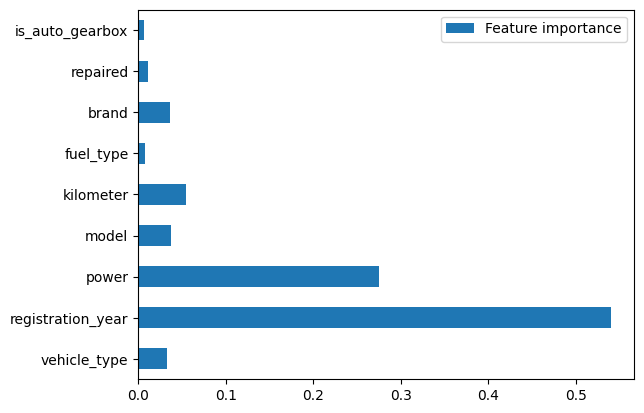

In [64]:
(
    pd.DataFrame(
        rf_model.feature_importances_,
        index=features_train.columns,
        columns=['Feature importance']
    ).plot(kind='barh')
);

### Подготовка признаков

In [65]:
features_train_lm, features_valid_lm, features_test_lm = features_train.copy(), features_valid.copy(), features_test.copy()

#### Масштабирование численных признаков

Проведем масштабирование численных признаков для реализации алгоритма линейной регрессии.

In [66]:
numeric_cols = np.delete(numeric_cols, 0)

In [67]:
scaler = StandardScaler()
scaler.fit(features_train_lm[numeric_cols])

features_train_lm[numeric_cols] = scaler.transform(features_train_lm[numeric_cols])
features_valid_lm[numeric_cols] = scaler.transform(features_valid_lm[numeric_cols])
features_test_lm[numeric_cols] = scaler.transform(features_test_lm[numeric_cols])

#### Кодирование категориальных признаков

In [68]:
ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

In [69]:
ohe.fit(features_train_lm[non_numeric_cols])

OneHotEncoder(drop='first', sparse=False)

In [70]:
features_train_lm[ohe.get_feature_names()] = \
    ohe.transform(features_train_lm[non_numeric_cols])

In [71]:
features_valid_lm[ohe.get_feature_names()] = \
    ohe.transform(features_valid_lm[non_numeric_cols])

features_test_lm[ohe.get_feature_names()] = \
    ohe.transform(features_test_lm[non_numeric_cols])

### Linear Regression

Обучим модель линейной регрессии и посмотрим результат.

In [72]:
lr_model = LinearRegression()

In [73]:
%%time
lr_model.fit(features_train_lm, target_train);

CPU times: total: 19.6 s
Wall time: 13.1 s


LinearRegression()

In [74]:
%%time
lr_pred = lr_model.predict(features_valid_lm)

CPU times: total: 609 ms
Wall time: 689 ms


In [75]:
mean_squared_error(target_valid, lr_pred) ** .5

2556.96014153947

In [76]:
lr_model

LinearRegression()

## Анализ моделей

Результаты тестирования моделей приведены в таблице

| Модель                | RMSE    | CPU times обучения | CPU times предсказания |
| --------------------- | ------  | ------------------ | ---------------------- |
| LGBMRegressor         | 1534.67 | 6.55 s             | 547 ms                 |
| RandomForestRegressor | 1530.22 | 12.4 s             | 188 ms                 |
| LinearRegression      | 2556.96 | 19.6 s             | 609 ms                 |

Выбор не совсем очевиден, однако, считаю, что модель RandomForestRegressor сработала лучше всех. Хоть она и обучается в 2 раза дольше, но зато предсказывает в 3 раза быстрее LGBMRegressor. При этом точность модели чуть выше. Модель Линейной регрессии не проходит по условию на минимальное RMSE.

## Тестирование модели

Посчитаем RMSE на тестовой выборке.

In [77]:
rf_model = RandomForestRegressor(n_estimators=20, max_depth=20, random_state=0)
rf_model.fit(features_train, target_train)
rf_pred = lgb_model.predict(features_test)

In [78]:
print('RMSE на тестовой выборке:', mean_squared_error(target_test, rf_pred) ** .5)

RMSE на тестовой выборке: 1537.416010454178


In [79]:
dummy_model = DummyRegressor(strategy='median')

dummy_model.fit(features_train, target_train)
dummy_pred = dummy_model.predict(features_test)

rmse = mean_squared_error(target_test, dummy_pred) ** .5
    
print('Итоговое RMSE на dummy-модели по медиане:', rmse)

Итоговое RMSE на dummy-модели по медиане: 4884.119589999078


**Вывод:** модель прошла проверку на адекватность. RandomForestRegressor - наш фаворит.

## Заключение

После длительной предобработки, включающей в себя переименование, чистку выбросов, заполнение пропусков, смену типов данных и удаление дубликатов, провели обучение 3 моделей: `LGBMRegressor`, `RandomForestRegressor` и `LinearRegression`.  По метрике RMSE и скорости работы наилучшей моделью стоит признать **LGBMRegressor** с гиперпараметрами n_estimators=150, learning_rate=0.25. 

Значение CPU Time = 6.38 s, RMSE = 1679.68.